<a href="https://colab.research.google.com/github/Sherry123-wang/token-metrics-project/blob/main/Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install yfinance ta xgboost

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0f90b0d7f44cb0d5f774fb4950ca77bb39cb578dd7a347c3d16cb44711ad9597
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [3]:
# 0. INSTALL REQUIRED PACKAGES

print("Installing required packages...")
import sys
import subprocess

packages = ['yfinance', 'ta', 'xgboost']
for package in packages:
    try:
        __import__(package)
        print(f" {package} already installed")
    except ImportError:
        print(f" Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f" {package} installed successfully")

Installing required packages...
 yfinance already installed
 ta already installed
 xgboost already installed


In [4]:
# 1. SETUP & DEPENDENCIES

import warnings
warnings.filterwarnings('ignore')

print("Importing libraries...")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

print(" Basic libraries imported")

# Data Collection
import yfinance as yf
print(" yfinance imported")

# ML Models
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix, classification_report
)
print(" sklearn imported")

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print(" XGBoost imported")
except ImportError:
    XGBOOST_AVAILABLE = False
    print(" XGBoost not available. Install with: !pip install xgboost")

# Technical Indicators
try:
    from ta.trend import MACD, EMAIndicator, SMAIndicator
    from ta.momentum import RSIIndicator, StochasticOscillator
    from ta.volatility import BollingerBands, AverageTrueRange
    print(" ta (technical analysis) imported")
except ImportError as e:
    print(f"Error importing ta: {e}")
    print("Please run: !pip install ta")
    raise

print("\n All libraries imported successfully!")


Importing libraries...
 Basic libraries imported
 yfinance imported
 sklearn imported
 XGBoost imported
 ta (technical analysis) imported

 All libraries imported successfully!


In [5]:
# 2. DATA COLLECTION

def fetch_crypto_data(symbols, period='60d'):
    """
    Fetch historical crypto data from Yahoo Finance

    Args:
        symbols: List of crypto ticker symbols
        period: Time period (60 days to ensure 30 days after indicators calculated)

    Returns:
        Dictionary of DataFrames for each symbol
    """
    data_dict = {}

    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(period=period)

            if len(df) > 0:
                data_dict[symbol] = df
                print(f"✓ {symbol}: {len(df)} days of data")
            else:
                print(f"✗ {symbol}: No data available")
        except Exception as e:
            print(f"✗ {symbol}: Error - {str(e)}")

    return data_dict

# Define crypto assets (8-12 major cryptocurrencies)
CRYPTO_SYMBOLS = [
    'BTC-USD',   # Bitcoin
    'ETH-USD',   # Ethereum
    'BNB-USD',   # Binance Coin
    'XRP-USD',   # Ripple
    'ADA-USD',   # Cardano
    'SOL-USD',   # Solana
    'DOGE-USD',  # Dogecoin
    'MATIC-USD', # Polygon
    'DOT-USD',   # Polkadot
    'AVAX-USD',  # Avalanche
]

print("\n" + "="*65)
print("FETCHING CRYPTOCURRENCY DATA")
print("="*65 + "\n")

raw_data = fetch_crypto_data(CRYPTO_SYMBOLS)



FETCHING CRYPTOCURRENCY DATA

✓ BTC-USD: 60 days of data
✓ ETH-USD: 60 days of data
✓ BNB-USD: 60 days of data
✓ XRP-USD: 60 days of data
✓ ADA-USD: 60 days of data
✓ SOL-USD: 60 days of data


ERROR:yfinance:$MATIC-USD: possibly delisted; no price data found  (period=60d)


✓ DOGE-USD: 60 days of data
✗ MATIC-USD: No data available
✓ DOT-USD: 60 days of data
✓ AVAX-USD: 60 days of data


In [6]:
# 3. FEATURE ENGINEERING - CREATE RATINGS/INDICATORS


def create_technical_indicators(df):
    """
    Create technical indicators as 'Ratings/Indicators'

    Returns:
        DataFrame with original price data and technical indicators
    """
    df = df.copy()

    # Basic Price Features
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Trend Indicators

    # 1. Moving Averages
    df['SMA_5'] = SMAIndicator(df['Close'], window=5).sma_indicator()
    df['SMA_10'] = SMAIndicator(df['Close'], window=10).sma_indicator()
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_5'] = EMAIndicator(df['Close'], window=5).ema_indicator()
    df['EMA_10'] = EMAIndicator(df['Close'], window=10).ema_indicator()

    # 2. MACD
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()

    # Momentum Indicators
    # 3. RSI (Relative Strength Index)
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()

    # 4. Stochastic Oscillator
    stoch = StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()

    # Volatility Indicators
    # 5. Bollinger Bands
    bollinger = BollingerBands(df['Close'])
    df['BB_High'] = bollinger.bollinger_hband()
    df['BB_Mid'] = bollinger.bollinger_mavg()
    df['BB_Low'] = bollinger.bollinger_lband()
    df['BB_Width'] = (df['BB_High'] - df['BB_Low']) / df['BB_Mid']

    # 6. Average True Range (ATR)
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()

    # 7. Volume Indicators
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']

    # 8. Price Position Indicators
    df['Price_to_SMA20'] = df['Close'] / df['SMA_20']
    df['Price_to_BB_Mid'] = df['Close'] / df['BB_Mid']

    # 9. Momentum Features
    df['ROC_5'] = df['Close'].pct_change(periods=5)  # Rate of Change
    df['ROC_10'] = df['Close'].pct_change(periods=10)

    # 10.Lag features (previous days' returns)
    df['Lag_1'] = df['Returns'].shift(1)
    df['Lag_2'] = df['Returns'].shift(2)
    df['Lag_3'] = df['Returns'].shift(3)
    df['Lag_4'] = df['Returns'].shift(4)
    df['Lag_5'] = df['Returns'].shift(5)

    # 11.Rolling statistics - expanded
    df['Volatility_5'] = df['Returns'].rolling(window=5).std()
    df['Volatility_10'] = df['Returns'].rolling(window=10).std()
    df['Volatility_20'] = df['Returns'].rolling(window=20).std()
    df['Return_Mean_3'] = df['Returns'].rolling(window=3).mean()
    df['Return_Mean_5'] = df['Returns'].rolling(window=5).mean()
    df['Return_Mean_10'] = df['Returns'].rolling(window=10).mean()
    df['Return_Mean_20'] = df['Returns'].rolling(window=20).mean()

    # 12. Rolling skewness and kurtosis
    df['Return_Skew_10'] = df['Returns'].rolling(window=10).skew()
    df['Return_Kurt_10'] = df['Returns'].rolling(window=10).kurt()

    # 13. Price momentum - expanded
    df['Momentum_3'] = df['Close'] / df['Close'].shift(3) - 1
    df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['Momentum_20'] = df['Close'] / df['Close'].shift(20) - 1

    # 14. Volume momentum - expanded
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_MA_Ratio_5'] = df['Volume'] / df['Volume'].rolling(window=5).mean()
    df['Volume_MA_Ratio_10'] = df['Volume'] / df['Volume'].rolling(window=10).mean()
    df['Volume_MA_Ratio_20'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
    df['Volume_Volatility'] = df['Volume'].rolling(window=10).std() / df['Volume'].rolling(window=10).mean()

    # 15. High-Low spread - expanded
    df['HL_Spread'] = (df['High'] - df['Low']) / df['Close']
    df['HL_Spread_MA_3'] = df['HL_Spread'].rolling(window=3).mean()
    df['HL_Spread_MA_5'] = df['HL_Spread'].rolling(window=5).mean()
    df['HL_Spread_MA_10'] = df['HL_Spread'].rolling(window=10).mean()

    # 16. Price position features
    df['Close_to_High'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
    df['Body_Size'] = abs(df['Close'] - df['Open']) / df['Close']

    # 17. RSI momentum
    df['RSI_Change'] = df['RSI'].diff()
    df['RSI_Momentum'] = df['RSI'] - df['RSI'].shift(3)

    # 18. MACD momentum
    df['MACD_Change'] = df['MACD'].diff()
    df['MACD_Momentum'] = df['MACD'] - df['MACD'].shift(3)

    # 19. Bollinger Band position
    df['BB_Position'] = (df['Close'] - df['BB_Low']) / (df['BB_High'] - df['BB_Low'])
    df['BB_Squeeze'] = (df['BB_Width'] < df['BB_Width'].rolling(window=20).quantile(0.25)).astype(int)

    # 20. Trend strength
    df['Trend_Strength'] = abs(df['SMA_5'] - df['SMA_20']) / df['SMA_20']
    df['EMA_Trend'] = (df['EMA_5'] > df['EMA_10']).astype(int)

    # 21. Price acceleration
    df['Price_Accel'] = df['Returns'].diff()
    df['Price_Accel_2'] = df['Price_Accel'].diff()

    # 22. Target Variable: Next Day Direction (1 = Up, 0 = Down)
    df['Next_Day_Return'] = df['Close'].shift(-1) / df['Close'] - 1
    df['Target'] = (df['Next_Day_Return'] > 0).astype(int)

    return df

print("\n" + "="*50)
print("CREATING TECHNICAL INDICATORS")
print("="*50 + "\n")

processed_data = {}
for symbol, df in raw_data.items():
    processed_df = create_technical_indicators(df)
    # Keep last 30 days as required by the exercise
    processed_df = processed_df.iloc[-30:]
    processed_data[symbol] = processed_df
    print(f"✓ {symbol}: {len(processed_df)} days with {processed_df.shape[1]} features")


CREATING TECHNICAL INDICATORS

✓ BTC-USD: 30 days with 72 features
✓ ETH-USD: 30 days with 72 features
✓ BNB-USD: 30 days with 72 features
✓ XRP-USD: 30 days with 72 features
✓ ADA-USD: 30 days with 72 features
✓ SOL-USD: 30 days with 72 features
✓ DOGE-USD: 30 days with 72 features
✓ DOT-USD: 30 days with 72 features
✓ AVAX-USD: 30 days with 72 features


In [7]:
# 4. PREPARE DATASET FOR MODELING

def prepare_ml_dataset(data_dict):
    """
    Combine all crypto data into a single dataset for modeling
    Enhanced with cross-asset features and time features
    """
    all_data = []

    for symbol, df in data_dict.items():
        df_copy = df.copy()
        df_copy['Symbol'] = symbol
        all_data.append(df_copy)

    # Combine all data
    combined_df = pd.concat(all_data, axis=0)

    # CRITICAL: Sort by date to ensure proper time series ordering
    # This is essential for TimeSeriesSplit to work correctly
    combined_df = combined_df.sort_index()

    # Add time-based features
    combined_df['Day_of_Week'] = combined_df.index.dayofweek
    combined_df['Day_of_Month'] = combined_df.index.day
    combined_df['Week_of_Year'] = combined_df.index.isocalendar().week
    combined_df['Month'] = combined_df.index.month

    # Calculate cross-asset features (market-wide indicators)
    # Group by date and calculate market statistics
    market_stats = combined_df.groupby(combined_df.index).agg({
        'Returns': ['mean', 'std', 'min', 'max'],
        'Volume': 'sum',
        'RSI': 'mean',
        'MACD': 'mean'
    })
    market_stats.columns = ['Market_Return_Mean', 'Market_Return_Std',
                            'Market_Return_Min', 'Market_Return_Max',
                            'Market_Volume_Sum', 'Market_RSI_Mean', 'Market_MACD_Mean']

    # Merge market stats back
    combined_df = combined_df.merge(market_stats, left_index=True, right_index=True, how='left')

    # Calculate relative features (asset vs market)
    combined_df['Return_vs_Market'] = combined_df['Returns'] - combined_df['Market_Return_Mean']
    combined_df['Volume_vs_Market'] = combined_df['Volume'] / (combined_df['Market_Volume_Sum'] / len(data_dict))
    combined_df['RSI_vs_Market'] = combined_df['RSI'] - combined_df['Market_RSI_Mean']

    # Select feature columns (exclude target and non-numeric columns)
    feature_cols = [
        # Basic features
        'Returns', 'Log_Returns',
        # Trend indicators
        'SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10',
        'MACD', 'MACD_Signal', 'MACD_Diff',
        # Momentum indicators
        'RSI', 'Stoch_K', 'Stoch_D',
        'ROC_5', 'ROC_10',
        # Volatility indicators
        'BB_Width', 'ATR',
        # Price position
        'Price_to_SMA20', 'Price_to_BB_Mid',
        # Lag features
        'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5',
        # Rolling statistics
        'Volatility_5', 'Volatility_10', 'Volatility_20',
        'Return_Mean_3', 'Return_Mean_5', 'Return_Mean_10', 'Return_Mean_20',
        'Return_Skew_10', 'Return_Kurt_10',
        # Momentum
        'Momentum_3', 'Momentum_5', 'Momentum_10', 'Momentum_20',
        # Volume features
        'Volume_Change', 'Volume_MA_Ratio_5', 'Volume_MA_Ratio_10', 'Volume_MA_Ratio_20', 'Volume_Volatility',
        # High-Low spread
        'HL_Spread', 'HL_Spread_MA_3', 'HL_Spread_MA_5', 'HL_Spread_MA_10',
        # New advanced features
        'Close_to_High', 'Body_Size',
        'RSI_Change', 'RSI_Momentum',
        'MACD_Change', 'MACD_Momentum',
        'BB_Position', 'BB_Squeeze',
        'Trend_Strength', 'EMA_Trend',
        'Price_Accel', 'Price_Accel_2',
        # Time features
        'Day_of_Week', 'Day_of_Month', 'Week_of_Year', 'Month',
        # Market features
        'Market_Return_Mean', 'Market_Return_Std', 'Market_Return_Min', 'Market_Return_Max',
        'Market_Volume_Sum', 'Market_RSI_Mean', 'Market_MACD_Mean',
        # Relative features
        'Return_vs_Market', 'Volume_vs_Market', 'RSI_vs_Market'
    ]

    # Remove rows with NaN values
    df_clean = combined_df.dropna(subset=feature_cols + ['Target'])

    X = df_clean[feature_cols]
    y = df_clean['Target']
    dates = df_clean.index
    symbols = df_clean['Symbol']

    return X, y, dates, symbols, df_clean

print("\n" + "="*60)
print("PREPARING ML DATASET")
print("="*60 + "\n")

X, y, dates, symbols, full_df = prepare_ml_dataset(processed_data)

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nFeatures used: {list(X.columns)}")

# Data Quality Check
print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)
print(f"Date range: {dates.min().date()} to {dates.max().date()}")
print(f"Number of unique dates: {dates.nunique()}")
print(f"Number of assets: {symbols.nunique()}")
print(f"Assets included: {sorted(symbols.unique())}")
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")


PREPARING ML DATASET

Dataset shape: (243, 72)
Target distribution:
Target
0    141
1    102
Name: count, dtype: int64

Features used: ['Returns', 'Log_Returns', 'SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10', 'MACD', 'MACD_Signal', 'MACD_Diff', 'RSI', 'Stoch_K', 'Stoch_D', 'ROC_5', 'ROC_10', 'BB_Width', 'ATR', 'Price_to_SMA20', 'Price_to_BB_Mid', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'Return_Mean_3', 'Return_Mean_5', 'Return_Mean_10', 'Return_Mean_20', 'Return_Skew_10', 'Return_Kurt_10', 'Momentum_3', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'Volume_Change', 'Volume_MA_Ratio_5', 'Volume_MA_Ratio_10', 'Volume_MA_Ratio_20', 'Volume_Volatility', 'HL_Spread', 'HL_Spread_MA_3', 'HL_Spread_MA_5', 'HL_Spread_MA_10', 'Close_to_High', 'Body_Size', 'RSI_Change', 'RSI_Momentum', 'MACD_Change', 'MACD_Momentum', 'BB_Position', 'BB_Squeeze', 'Trend_Strength', 'EMA_Trend', 'Price_Accel', 'Price_Accel_2', 'Day_of_Week', 'Day_of_Month', 'Wee

In [8]:
# 5. MODEL TRAINING WITH ROLLING WINDOW VALIDATION


def rolling_window_validation(X, y, dates, n_splits=5):
    """
    Perform rolling window validation (walk-forward analysis)

    Args:
        X: Feature matrix (must be sorted by date)
        y: Target vector (must be sorted by date)
        dates: Date index (must be sorted chronologically)
        n_splits: Number of folds for cross-validation

    Returns:
        results: Dictionary of model performance metrics per fold
        all_predictions: Dictionary of all predictions per model
        all_actuals: List of all actual values
        fold_info: List of fold information (sizes, dates)
        models: Dictionary of trained models (last fold)
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize models with optimized hyperparameters for better precision
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42,
            max_iter=3000,
            C=0.1,  # Lower C value, increase regularization, reduce overfitting
            class_weight={0: 1, 1: 2},  # Higher weight for UP class, but not excessive
            solver='lbfgs',
            penalty='l2'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=300,  # Increase number of trees
            random_state=42,
            max_depth=8,  # Lower depth, reduce overfitting
            min_samples_split=10,  # Increase minimum samples to split
            min_samples_leaf=5,  # Increase minimum samples in leaf
            class_weight={0: 1, 1: 1.5},  # Moderate class weight adjustment
            n_jobs=-1,
            max_features='sqrt'  # Use sqrt of features, reduce overfitting
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=300,
            random_state=42,
            max_depth=4,  # Lower depth
            learning_rate=0.03,  # Lower learning rate, more conservative
            subsample=0.7,  # Lower subsample ratio
            min_samples_split=10,  # Increase minimum samples to split
            min_samples_leaf=5  # Increase minimum samples in leaf
        )
    }

    if XGBOOST_AVAILABLE:
        models['XGBoost'] = xgb.XGBClassifier(
            n_estimators=300,
            max_depth=4,  # Lower depth
            learning_rate=0.03,  # Lower learning rate, more conservative
            subsample=0.7,  # Lower subsample ratio
            colsample_bytree=0.7,  # Lower feature sampling ratio
            min_child_weight=5,  # Increase minimum child weight
            gamma=0.1,  # Increase minimum loss reduction
            random_state=42,
            eval_metric='logloss',
            use_label_encoder=False,
            scale_pos_weight=1  # Will be adjusted based on class distribution
        )

    results = {name: [] for name in models.keys()}
    all_predictions = {name: [] for name in models.keys()}
    all_actuals = []
    fold_info = []

    print("\n" + "="*70)
    print("ROLLING WINDOW VALIDATION")
    print("="*70 + "\n")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Store test dates for this fold
        test_dates = dates[test_idx]

        # Feature selection: Select top K features based on F-statistic
        # Use 80% of features to avoid overfitting
        k_features = min(int(0.8 * X_train.shape[1]), X_train.shape[1])
        feature_selector = SelectKBest(f_classif, k=k_features)
        X_train_selected = feature_selector.fit_transform(X_train, y_train)
        X_test_selected = feature_selector.transform(X_test)

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)

        print(f"\nFold {fold}:")
        print(f"  Train: {len(train_idx)} samples | Test: {len(test_idx)} samples")
        print(f"  Test period: {test_dates.min().date()} to {test_dates.max().date()}")
        print(f"  Features selected: {k_features} out of {X_train.shape[1]}")
        print(f"  Class distribution - Train: {y_train.value_counts().to_dict()}, Test: {y_test.value_counts().to_dict()}")

        fold_info.append({
            'fold': fold,
            'train_size': len(train_idx),
            'test_size': len(test_idx),
            'test_start': test_dates.min(),
            'test_end': test_dates.max(),
            'n_features': k_features
        })

        # Train and evaluate each model
        for name, model in models.items():
            # Adjust XGBoost scale_pos_weight for class imbalance
            if name == 'XGBoost' and XGBOOST_AVAILABLE:
                # Calculate class weight ratio
                class_counts = y_train.value_counts()
                if len(class_counts) == 2:
                    scale_pos_weight = class_counts[0] / class_counts[1] * 1.2  # Moderate adjustment
                    model.set_params(scale_pos_weight=scale_pos_weight)

            # Train
            model.fit(X_train_scaled, y_train)

            # Get probability predictions and apply custom threshold (0.6 for better precision)
            y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of UP class
            y_pred = (y_proba >= 0.6).astype(int)  # Use threshold 0.6 instead of default 0.5

            # Calculate metrics
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            accuracy = accuracy_score(y_test, y_pred)

            results[name].append({
                'fold': fold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy
            })

            all_predictions[name].extend(y_pred)

        all_actuals.extend(y_test)

    return results, all_predictions, all_actuals, fold_info, models

# Run rolling window validation
results, predictions, actuals, fold_info, trained_models = rolling_window_validation(X, y, dates)


ROLLING WINDOW VALIDATION


Fold 1:
  Train: 43 samples | Test: 40 samples
  Test period: 2025-10-25 to 2025-10-30
  Features selected: 57 out of 72
  Class distribution - Train: {1: 32, 0: 11}, Test: {0: 32, 1: 8}

Fold 2:
  Train: 83 samples | Test: 40 samples
  Test period: 2025-10-30 to 2025-11-03
  Features selected: 57 out of 72
  Class distribution - Train: {0: 43, 1: 40}, Test: {1: 20, 0: 20}

Fold 3:
  Train: 123 samples | Test: 40 samples
  Test period: 2025-11-03 to 2025-11-08
  Features selected: 57 out of 72
  Class distribution - Train: {0: 63, 1: 60}, Test: {0: 20, 1: 20}

Fold 4:
  Train: 163 samples | Test: 40 samples
  Test period: 2025-11-08 to 2025-11-12
  Features selected: 57 out of 72
  Class distribution - Train: {0: 83, 1: 80}, Test: {0: 26, 1: 14}

Fold 5:
  Train: 203 samples | Test: 40 samples
  Test period: 2025-11-12 to 2025-11-16
  Features selected: 57 out of 72
  Class distribution - Train: {0: 109, 1: 94}, Test: {0: 32, 1: 8}


In [9]:
# 6. EVALUATION & RESULTS


print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60 + "\n")

# Aggregate results across folds
summary_df = pd.DataFrame()

for model_name, fold_results in results.items():
    df = pd.DataFrame(fold_results)
    avg_metrics = df[['precision', 'recall', 'f1', 'accuracy']].mean()
    avg_metrics['model'] = model_name
    summary_df = pd.concat([summary_df, pd.DataFrame([avg_metrics])], ignore_index=True)

summary_df = summary_df[['model', 'precision', 'recall', 'f1', 'accuracy']]
print(summary_df.to_string(index=False))

# Calculate practical decision metric: Profitable Trade Ratio
print("\n" + "="*60)
print("PRACTICAL DECISION METRIC")
print("="*60 + "\n")

def calculate_profit_metrics(predictions, actuals):
    """
    Calculate practical trading metrics
    """
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # When we predict UP (1), what's our success rate?
    up_predictions = predictions == 1
    if up_predictions.sum() > 0:
        profitable_up_trades = (predictions[up_predictions] == actuals[up_predictions]).sum()
        up_success_rate = profitable_up_trades / up_predictions.sum()
    else:
        up_success_rate = 0

    # When we predict DOWN (0), what's our success rate?
    down_predictions = predictions == 0
    if down_predictions.sum() > 0:
        profitable_down_trades = (predictions[down_predictions] == actuals[down_predictions]).sum()
        down_success_rate = profitable_down_trades / down_predictions.sum()
    else:
        down_success_rate = 0

    return {
        'up_success_rate': up_success_rate,
        'down_success_rate': down_success_rate,
        'total_accuracy': (predictions == actuals).sum() / len(actuals),
        'up_trade_count': up_predictions.sum(),
        'down_trade_count': down_predictions.sum()
    }

for model_name, preds in predictions.items():
    metrics = calculate_profit_metrics(preds, actuals)
    print(f"\n{model_name}:")
    print(f"  UP predictions success rate: {metrics['up_success_rate']:.2%} ({metrics['up_trade_count']} trades)")
    print(f"  DOWN predictions success rate: {metrics['down_success_rate']:.2%} ({metrics['down_trade_count']} trades)")
    print(f"  Overall accuracy: {metrics['total_accuracy']:.2%}")


MODEL PERFORMANCE SUMMARY

              model  precision   recall       f1  accuracy
Logistic Regression   0.379933 0.817857 0.500323     0.470
      Random Forest   0.343703 0.587857 0.409979     0.445
  Gradient Boosting   0.335765 0.650714 0.415730     0.440
            XGBoost   0.328463 0.548571 0.386119     0.545

PRACTICAL DECISION METRIC


Logistic Regression:
  UP predictions success rate: 37.67% (146 trades)
  DOWN predictions success rate: 72.22% (54 trades)
  Overall accuracy: 47.00%

Random Forest:
  UP predictions success rate: 32.48% (117 trades)
  DOWN predictions success rate: 61.45% (83 trades)
  Overall accuracy: 44.50%

Gradient Boosting:
  UP predictions success rate: 33.59% (128 trades)
  DOWN predictions success rate: 62.50% (72 trades)
  Overall accuracy: 44.00%

XGBoost:
  UP predictions success rate: 39.39% (99 trades)
  DOWN predictions success rate: 69.31% (101 trades)
  Overall accuracy: 54.50%



GENERATING VISUALIZATIONS

✓ Visualization saved as 'crypto_prediction_results.png'


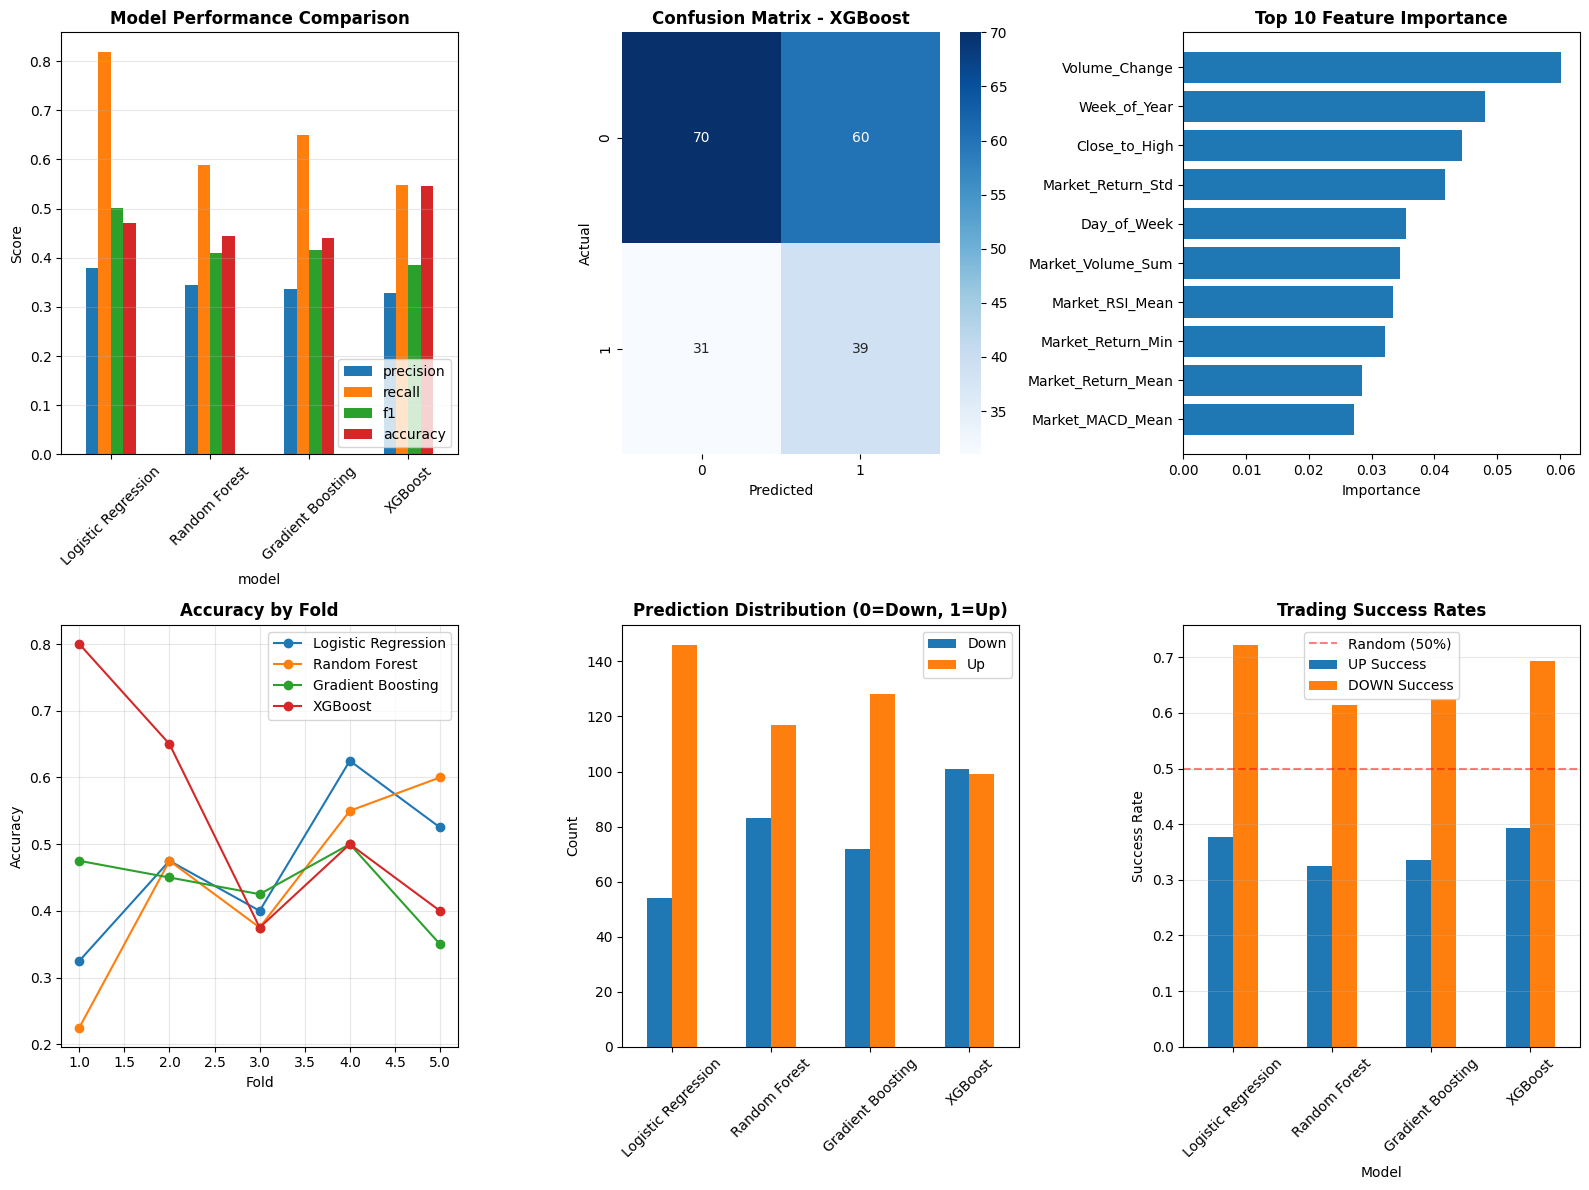

In [10]:
 # 7. VISUALIZATIONS

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60 + "\n")

try:
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))

    # 1. Model Comparison - Metrics
    ax1 = plt.subplot(2, 3, 1)
    if 'summary_df' in globals() and summary_df is not None and len(summary_df) > 0:
        summary_df.set_index('model')[['precision', 'recall', 'f1', 'accuracy']].plot(
            kind='bar', ax=ax1, rot=45
        )
        ax1.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Score')
        ax1.legend(loc='lower right')
        ax1.grid(axis='y', alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')

    # 2. Confusion Matrix - Best Model
    ax2 = plt.subplot(2, 3, 2)
    # Find best model by accuracy
    if 'summary_df' in globals() and summary_df is not None and len(summary_df) > 0:
        best_model = summary_df.loc[summary_df['accuracy'].idxmax(), 'model']
    else:
        best_model = list(predictions.keys())[0] if predictions else 'Random Forest'

    if best_model in predictions and len(actuals) > 0:
        cm = confusion_matrix(actuals, predictions[best_model])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
        ax2.set_title(f'Confusion Matrix - {best_model}', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Actual')
        ax2.set_xlabel('Predicted')
    else:
        ax2.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title(f'Confusion Matrix - {best_model}', fontsize=12, fontweight='bold')

    # 3. Feature Importance
    ax3 = plt.subplot(2, 3, 3)
    try:
        # Train a simple Random Forest on all data to get feature importance
        # This avoids the feature selection mismatch issue
        if 'X' in globals() and 'y' in globals() and len(X) > 0 and len(y) > 0:
            # Use a simple Random Forest trained on all features for feature importance
            rf_for_importance = RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                max_depth=10,
                n_jobs=-1
            )

            # Train on all data (for visualization purposes only)
            rf_for_importance.fit(X, y)

            # Get feature importance
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': rf_for_importance.feature_importances_
            }).sort_values('importance', ascending=False).head(10)

            if len(feature_importance) > 0 and feature_importance['importance'].sum() > 0:
                ax3.barh(feature_importance['feature'], feature_importance['importance'])
                ax3.set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
                ax3.set_xlabel('Importance')
                ax3.invert_yaxis()
            else:
                ax3.text(0.5, 0.5, 'No feature data', ha='center', va='center', transform=ax3.transAxes)
                ax3.set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
        else:
            ax3.text(0.5, 0.5, 'X or y not available', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
    except Exception as e:
        print(f"Feature importance error: {str(e)}")
        ax3.text(0.5, 0.5, f'Error: {str(e)[:30]}', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')

    # 4. Performance by Fold
    ax4 = plt.subplot(2, 3, 4)
    if 'results' in globals() and results:
        for model_name, fold_results in results.items():
            df = pd.DataFrame(fold_results)
            if 'fold' in df.columns and 'accuracy' in df.columns:
                ax4.plot(df['fold'], df['accuracy'], marker='o', label=model_name)
        ax4.set_title('Accuracy by Fold', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Fold')
        ax4.set_ylabel('Accuracy')
        ax4.legend()
        ax4.grid(alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Accuracy by Fold', fontsize=12, fontweight='bold')

    # 5. Prediction Distribution
    ax5 = plt.subplot(2, 3, 5)
    if 'predictions' in globals() and predictions:
        prediction_counts = pd.DataFrame({
            model: pd.Series(preds).value_counts()
            for model, preds in predictions.items()
        })
        if len(prediction_counts) > 0:
            prediction_counts.T.plot(kind='bar', ax=ax5, rot=45)
            ax5.set_title('Prediction Distribution (0=Down, 1=Up)', fontsize=12, fontweight='bold')
            ax5.set_ylabel('Count')
            ax5.legend(['Down', 'Up'])
        else:
            ax5.text(0.5, 0.5, 'No predictions', ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Prediction Distribution (0=Down, 1=Up)', fontsize=12, fontweight='bold')
    else:
        ax5.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Prediction Distribution (0=Down, 1=Up)', fontsize=12, fontweight='bold')

    # 6. Success Rate by Model
    ax6 = plt.subplot(2, 3, 6)
    if 'predictions' in globals() and predictions and 'actuals' in globals() and len(actuals) > 0:
        success_rates = []
        for model_name, preds in predictions.items():
            try:
                metrics = calculate_profit_metrics(preds, actuals)
                success_rates.append({
                    'Model': model_name,
                    'UP Success': metrics['up_success_rate'],
                    'DOWN Success': metrics['down_success_rate']
                })
            except:
                continue

        if len(success_rates) > 0:
            success_df = pd.DataFrame(success_rates)
            success_df.set_index('Model')[['UP Success', 'DOWN Success']].plot(
                kind='bar', ax=ax6, rot=45
            )
            ax6.set_title('Trading Success Rates', fontsize=12, fontweight='bold')
            ax6.set_ylabel('Success Rate')
            ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random (50%)')
            ax6.legend()
            ax6.grid(axis='y', alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax6.transAxes)
            ax6.set_title('Trading Success Rates', fontsize=12, fontweight='bold')
    else:
        ax6.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Trading Success Rates', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('crypto_prediction_results.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved as 'crypto_prediction_results.png'")
    plt.show()

except Exception as e:
    print(f"Error generating visualizations: {str(e)}")
    import traceback
    traceback.print_exc()